# Slicing and dicing baseball statistics

Analysing Major League Baseball batting statistics from 1876 to present, to see what I could find.

![title](Barry-Bonds.jpg)

## 1. Prep work

### 1.1 Import tools and data

In [75]:
# Load the holy trinity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [76]:
# Dataset downloaded from https://www.kaggle.com/datasets/logancuster/baseball-seasons-data
df = pd.read_csv('mlb_season_data.csv')

C:\Users\tim55\AppData\Local\Temp\ipykernel_16356\687405408.py:2: DtypeWarning: Columns (13,16,17,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('mlb_season_data.csv')


### 1.3 Quick glossary of terms

A quick overview of the terms, which I have oversimplified so that the findings in this notebook are accessible for those unfamiliar with the sport.

**At bat:** Each time a player faces the pitcher

<img src="baseball-atbat.gif" width="400">

**Hit:** The batter hits the ball and advances to first base (or beyond)

<img src="baseball-hit.gif" width="400">

**Home run:** The batter hits the ball all the way into the crowd, allowing them round all of the bases and score a run

<img src="baseball-homerun.gif" width="400">

**Walk:** Four bad pitches allows the batter to advance to first base

<img src="baseball-walk.gif" width="400">

**Strikeout:** Three misses by the batter result in an out and his at bat is over

<img src="baseball-strikeout.gif" width="400">

**Batting average:** A measure of success: a percentage score of how many of a player's at bats result in a hit to first base (or beyond)

**On base percentage:** A newer measure of success: a percentage score of how many of a player's at bats result in a hit or a walk

**Stolen base:** While on a base, a player cheekily runs to the next base while the opposition aren't looking

<img src="baseball-stolenbase.gif" width="400">

**Caught stealing:** An attempt at a stolen base, where the opposition catches them, and they are called out.

<img src="baseball-caughtstealing.gif" width="400">

## 2. Clean and prepare the data

### 2.1 Explore the dataset

In [77]:
df.head(10)

,season,first_name,last_name,link,position,team,games_played,at_bats,runs,hits,...,homeruns,rbi,walks,strikeouts,stolen_bases,caught_stealing,batting_average,on_base_percentage,slugging_percentage,on_base_plus_slugging
0,1876,Bob,Addy,/player/110074,X,CHI,32,142,36,40,...,0,16,5,0.0,--,--,0.282,--,0.324,--
1,1876,Art,Allison,/player/110170,X,LOU,31,130,9,27,...,0,10,2,6.0,--,--,0.208,--,0.238,--
2,1876,Doug,Allison,/player/110172,C,HAR,44,163,19,43,...,0,15,3,9.0,--,--,0.264,--,0.288,--
3,1876,Fred,Andrus,/player/110275,X,CHI,8,36,6,11,...,0,2,0,5.0,--,--,0.306,--,0.389,--
4,1876,Cap,Anson,/player/110284,3B,CHI,66,309,63,110,...,2,59,12,8.0,--,--,0.356,--,0.450,--
5,1876,Ross,Barnes,/player/110587,2B,CHI,66,322,126,138,...,1,59,20,8.0,--,--,0.429,--,0.590,--
6,1876,Joe,Battin,/player/110691,3B,STL,64,283,34,85,...,0,46,6,6.0,--,--,0.300,--,0.367,--
7,1876,George,Bechtel,/player/110756,X,LOU,16,65,4,13,...,0,2,0,1.0,--,--,0.200,--,0.215,--
8,1876,John,Bergh,/player/110905,C,PHN,1,4,0,0,...,0,0,0,2.0,--,--,0.000,--,0.000,--
9,1876,Oscar,Bielaski,/player/110978,X,CHI,32,139,24,29,...,0,10,2,3.0,--,--,0.209,--,0.230,--


From this we can see that each row of the dataset represents an individual and their performance in a given season.
So for example, in 1876, Bob Addy played in 32 games and recorded 40 hits, but did not score any home runs.

### 2.2 Fixing the error

We can also see that there are some columns without values, and this is because those statistics hadn't been invented, and weren't being recorded, back in 1876.
However, rather than being left blank, these entries have been marked as a double hyphen, which is causing the above error.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104067 entries, 0 to 104066
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   season                 104067 non-null  int64  
 1   first_name             103751 non-null  object 
 2   last_name              104067 non-null  object 
 3   link                   104067 non-null  object 
 4   position               104067 non-null  object 
 5   team                   104067 non-null  object 
 6   games_played           104067 non-null  int64  
 7   at_bats                104067 non-null  int64  
 8   runs                   104067 non-null  int64  
 9   hits                   104067 non-null  int64  
 10  doubles                104067 non-null  int64  
 11  triples                104067 non-null  int64  
 12  homeruns               104067 non-null  int64  
 13  rbi                    104067 non-null  object 
 14  walks                  104067 non-nu

We can see that columns such as "rbi", "stolen_bases" and "on_base_percentage" which should either be an integer or float, are appearing as a string. This is causing the error above, and will hamper our statistical analysis later.
We'll now run a piece of code which converts the columns to numbers, removing any data which isn't numerical.

In [79]:
# Some columns represent the number of instances that an event occur, and can therefore be recorded as a whole number, or integer
counting_columns = ["rbi", "stolen_bases", "caught_stealing", "strikeouts"]
# Other columns represent averages and percentages, meaning they will be recorded as a float
percentage_columns = ["on_base_percentage", "on_base_plus_slugging"]

for col in counting_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
for col in percentage_columns:
   df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104067 entries, 0 to 104066
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   season                 104067 non-null  int64  
 1   first_name             103751 non-null  object 
 2   last_name              104067 non-null  object 
 3   link                   104067 non-null  object 
 4   position               104067 non-null  object 
 5   team                   104067 non-null  object 
 6   games_played           104067 non-null  int64  
 7   at_bats                104067 non-null  int64  
 8   runs                   104067 non-null  int64  
 9   hits                   104067 non-null  int64  
 10  doubles                104067 non-null  int64  
 11  triples                104067 non-null  int64  
 12  homeruns               104067 non-null  int64  
 13  rbi                    103484 non-null  Int64  
 14  walks                  104067 non-nu

### 2.3 Clearing out unneccessary records

<img src="Paul-Skenes.gif" width="400">

From the dataset above we can see that each individual's primary position on the field is recorded. For example, 1B if they played first base, or LF if they played in left field.

In [80]:
df["position"].value_counts()

position
P     39782
C     10989
X      7164
2B     6918
LF     6697
3B     6607
SS     6575
1B     6131
RF     6109
CF     5696
DH     1236
PH      103
OF       35
PR       25
Name: count, dtype: int64

We can see that P (pitchers) account for almost half the dataset. Pitchers, however, rarely bat, and when they do so are not required to be very good at it. 

Similarly, PR (pinch runners) are substitutes who replace batters to run around the bases. As such, they rarely bat and are not usually required to be good at it when they do.

So we'll remove those players from our dataset.

In [81]:
df = df[df['position'] != "P"]
df = df[df['position'] != "PR"]
df['position'].value_counts()

position
C     10989
X      7164
2B     6918
LF     6697
3B     6607
SS     6575
1B     6131
RF     6109
CF     5696
DH     1236
PH      103
OF       35
Name: count, dtype: int64

## 3. Searching through the data

### 3.1 Finding who scored the most home runs in a season

With a simple search, we can find out which player scored the most homeruns in any one season.

In [82]:
# The first part of this code only selects the columns that it's useful to view right now
# The second part sorts the 'homeruns' column in descending order
# The third part shows the top 10 results
df[['first_name','last_name','season','games_played','homeruns']].sort_values(by=['homeruns'], ascending=False)[0:10]

,first_name,last_name,season,games_played,homeruns
77265,Barry,Bonds,2001,153,73
73927,Mark,McGwire,1998,155,70
73938,Sammy,Sosa,1998,159,66
75028,Mark,McGwire,1999,153,65
77273,Sammy,Sosa,2001,160,64
75042,Sammy,Sosa,1999,162,63
101767,Aaron,Judge,2022,157,62
45224,Roger,Maris,1961,161,61
21361,Babe,Ruth,1927,151,60
96014,Giancarlo,Stanton,2017,159,59


Here we can see that in 2001, Barry Bonds scored 73 home runs, more than any other player in any other season.

### 3.2 Finding the highest batting averages

Batting average is a score which represents how often a player could hit the ball and progress to first base. The higher the number, the more consistently well the player played.

Because averages can be skewed by small sample sizes. For example, a player who successfully made it to first base in his one and only turn would score 100%, and would be an unfair comparison against the players who played day-in-day out. So while this piece of code is similar to the above, it limits it to players who had 300 or more 'at bats' (which just means 'turns').

In [83]:
# The code is similar to previous, but at the start includes an element that filters out players with 300 bats
df[(df['at_bats'] >= 300)][['first_name','last_name','season','games_played','batting_average']].sort_values(by=['batting_average'], ascending=False)[0:10]

,first_name,last_name,season,games_played,batting_average
4788,Hugh,Duffy,1894,125,0.440
2424,Tip,O'Neill,1887,124,0.435
5,Ross,Barnes,1876,66,0.429
20520,Mule,Suttles,1926,89,0.425
18807,Rogers,Hornsby,1924,143,0.424
5607,Willie,Keeler,1897,129,0.424
21374,Roy,Parnell,1927,87,0.422
6667,Nap,Lajoie,1901,131,0.421
10836,Ty,Cobb,1911,146,0.420
17361,George,Sisler,1922,142,0.420


Here we can see that in 1894, Hugh Duffy played 125 games with a batting average of 0.440. Which is to say that 44% of the times it was his turn, he hit the ball and at least made it to first base.

We can also see that no season since 1927 is represented in the top 10 list.

If we want to see which of the 'modern' players have the highest batting average, we can add in a further element to the code, which as well as filtering out any player with fewer than 300 at bats, also filters out any season before 1940.

In [84]:
df[(df['at_bats'] >= 300)&(df['season'] >= 1940)][['first_name','last_name','season','games_played','batting_average']].sort_values(by=['batting_average'], ascending=False)[0:10]

,first_name,last_name,season,games_played,batting_average
31728,Ted,Williams,1941,143,0.406
70298,Tony,Gwynn,1994,110,0.394
59281,George,Brett,1980,117,0.390
42913,Ted,Williams,1957,132,0.388
57077,Rod,Carew,1977,155,0.388
75025,Larry,Walker,1999,127,0.379
37712,Stan,Musial,1948,155,0.376
76153,Todd,Helton,2000,160,0.372
80717,Ichiro,Suzuki,2004,161,0.372
76168,Nomar,Garciaparra,2000,140,0.372


## 4. Visualising trends through the years

The data above suggests that there are trends - batting averages were higher in the 1800s, whereas eight of the top ten home runs seasons occurred in 1998 or later.

Let's use graphs to see how things have changed over time.

### 4.1 Plotting what happens per each at bat

The graph above shows a clear trend in the increase in the top home run scorer and a definite, but more subtle increase in the mean homeruns scored per player, per season.

However, this suffers from the problem outlined in our earlier data - small sample sizes from players who didn't play very much. Someone who had a single at bat and didn't score a home run is a zero in our dataset, but doesn't really tell us much about the wider trends.

To get a more accurate picture, we'll do some calculations to see what happened per at bat.

In [85]:
# Group the data by season, so we can see how it changes over time
at_bat_outcomes = df.groupby('season').sum()

# Add the number of occurances, and divide it by the number of attempts to get a per centage
at_bat_outcomes['hits'] = (at_bat_outcomes['hits'] / at_bat_outcomes['at_bats']) * 100
at_bat_outcomes['homeruns'] = (at_bat_outcomes['homeruns'] / at_bat_outcomes['at_bats']) * 100
at_bat_outcomes['strikeouts'] = (at_bat_outcomes['strikeouts'] / at_bat_outcomes['at_bats']) * 100
at_bat_outcomes['walks'] = (at_bat_outcomes['walks'] / at_bat_outcomes['at_bats']) * 100
at_bat_outcomes['stolen_bases'] = (at_bat_outcomes['stolen_bases'] / at_bat_outcomes['at_bats']) * 100

array([[<Axes: xlabel='season'>, <Axes: xlabel='season'>],
       [<Axes: xlabel='season'>, <Axes: xlabel='season'>],
       [<Axes: xlabel='season'>, <Axes: xlabel='season'>]], dtype=object)

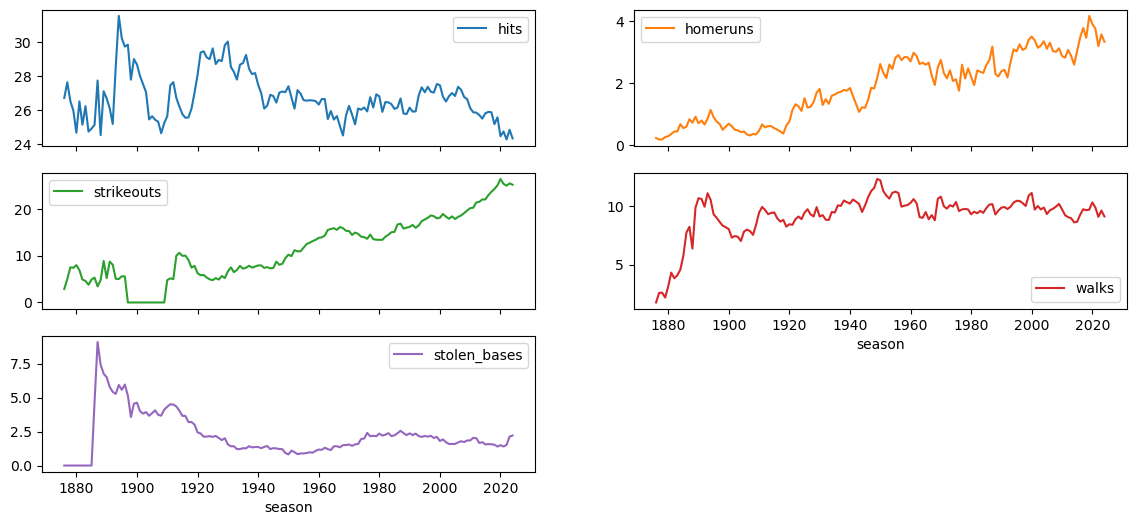

In [86]:
boxplot_cols = ['hits', 'homeruns', 'strikeouts', 'walks','stolen_bases']

# Show the graphs individually with subplots=true
at_bat_outcomes[boxplot_cols].plot(subplots=True, layout=(3,2), figsize=(14,6))

<Axes: xlabel='season'>

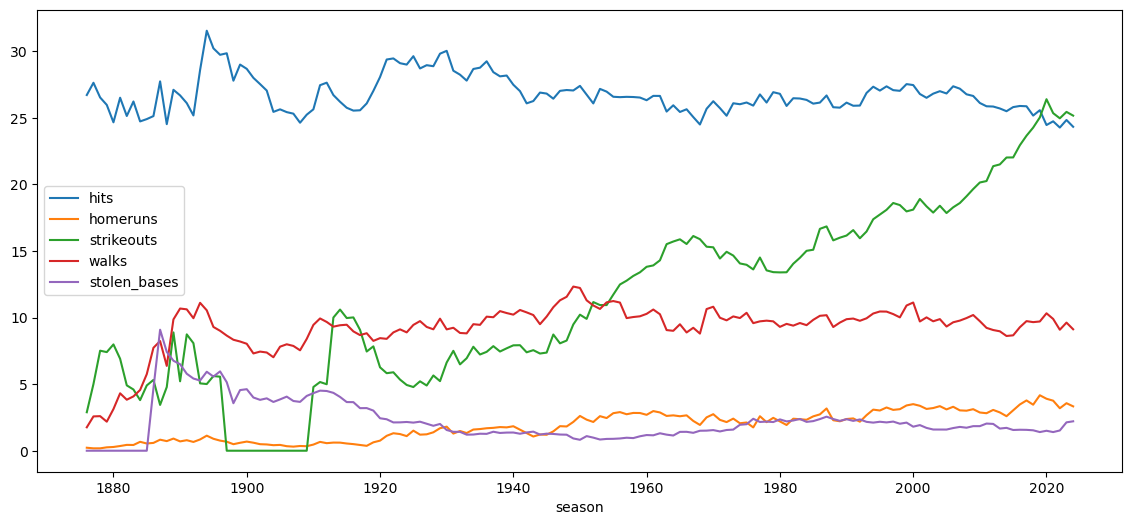

In [87]:
at_bat_outcomes[boxplot_cols].plot(figsize=(14, 6))

### 4.2 Plotting homerun totals by year

Another way of showing how often home runs occur now compared with earlier years is to show the rate of accumulation over the years. I've also included percentile markers to highlight how it has accelerated.

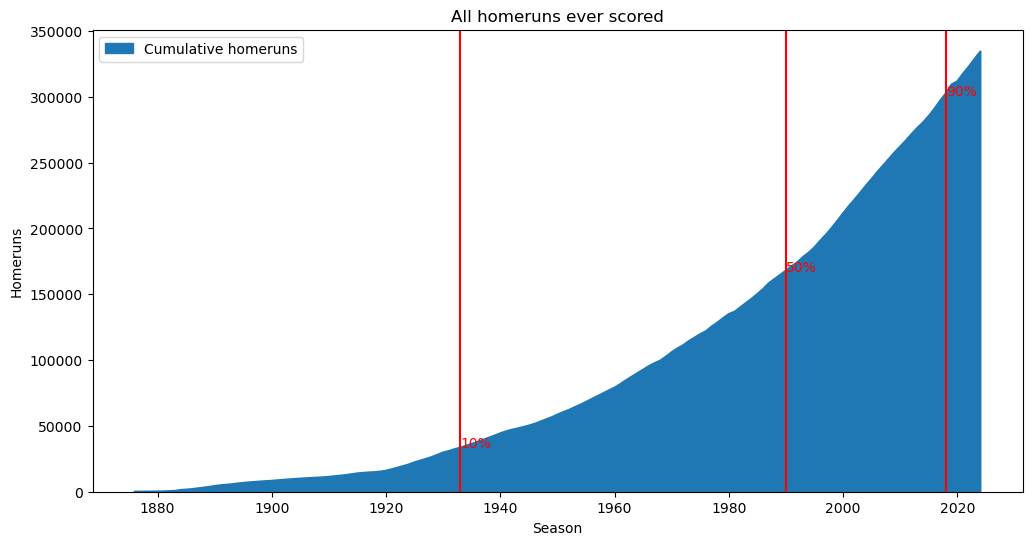

In [88]:
homerun_counter = df.groupby('season')['homeruns'].sum().reset_index()
homerun_counter['Cumulative homeruns'] = homerun_counter['homeruns'].cumsum()
homerun_total = homerun_counter['Cumulative homeruns'].iloc[-1]
percentiles = [0.1 * homerun_total, 0.50 * homerun_total, 0.9 * homerun_total]

# Set 'season' as the index for plotting
homerun_counter.set_index('season', inplace=True)

homerun_graph = pd.DataFrame(homerun_counter['Cumulative homeruns'])
homerun_graph.plot(kind='area', figsize=(12, 6))

# Plot the percentile lines and corresponding seasons
for percentile in percentiles:
    season = homerun_counter[homerun_counter['Cumulative homeruns'] >= percentile].index[0]
    plt.axvline(x=season, color='red')
    plt.text(x=season, y=percentile, s=f'{int(percentile / homerun_total * 100)}%', color='red')

plt.title("All homeruns ever scored")
plt.xlabel("Season")
plt.ylabel("Homeruns")
plt.show()


## 5. Aggregating the data

So far, we have treated each player's individual season as its own achievement, but players' careers often last many years. By aggregating the data, we can explore which player had the highest stats throughout the entirety of their career.

### 5.1 Grouping player records together

<img src="David-Ortiz.jpg" width="400">

For example, here is David Ortiz in our existing data set:

In [89]:
davidortiz = df[df['link'] == '/player/120074']
print(davidortiz[['season', 'first_name', 'last_name','position','team','games_played', 'homeruns']])

       season first_name last_name position team  games_played  homeruns
73039    1997      David     Ortiz       1B  MIN            15         1
74090    1998      David     Ortiz       1B  MIN            86         9
75794    1999      David     Ortiz        X  MIN            10         0
76357    2000      David     Ortiz       DH  MIN           130        10
77452    2001      David     Ortiz       DH  MIN            89        18
78510    2002      David     Ortiz       DH  MIN           125        20
79550    2003      David     Ortiz       DH  BOS           128        31
80664    2004      David     Ortiz       DH  BOS           150        41
81789    2005      David     Ortiz       DH  BOS           159        47
82930    2006      David     Ortiz       DH  BOS           151        54
84060    2007      David     Ortiz       DH  BOS           149        35
85297    2008      David     Ortiz       DH  BOS           109        23
86569    2009      David     Ortiz       DH  BOS   

By aggregating the data, we can condense all of the seasons into one record.

In [90]:
# Create a new dataset with aggregated data
# Using the 'link' column, as that's the one marker that is unique to each player and remains consist
player_group = df.groupby("link").agg(
# Choose which data to collect, and how the handle multiple instances
# First name will be constant throughout, so we can just take the first instance
    first_name=('first_name', 'first'),
    last_name=('last_name', 'first'),
    first_season=('season', 'first'),
# It'll be interesting to know when they last finished, so we'll record the last season they appeared
    last_season=('season', 'last'),
# And count the number of seasons, which will not be the same as last minus first if there was a break for any reason
    total_seasons=('season', 'count'),
# We want to know how many games they played and homeruns they scored in total, so we'll add these values together
    games_played=('games_played', 'sum'),
    at_bats=('at_bats', 'sum'),
    hits=('hits', 'sum'),
    walks=('walks', 'sum'),
    homeruns=('homeruns', 'sum'),
# Because their position and team played for may change throughout their career, but we want a record of each, we'll concatenate the results we find
    all_positions=('position', lambda x: ', '.join(map(str, sorted(set(x))))),
    all_teams=('team', lambda x: ', '.join(map(str, sorted(set(x))))),
# Using lamba and the count unique feature to see how many teams a player played for    
    teams_count=('team', lambda x: x.nunique()),
).reset_index()

In [91]:
davidortiz = player_group[player_group['link'] == '/player/120074']
davidortiz

,link,first_name,last_name,first_season,last_season,total_seasons,games_played,at_bats,hits,walks,homeruns,all_positions,all_teams,teams_count
5735,/player/120074,David,Ortiz,1997,2016,20,2408,8640,2472,1319,541,"1B, DH, X","BOS, MIN",2


### 5.2 Exploring the aggregated dataset

And now we can sort the list to find interesting things - such as who scored the most home runs in their career

In [92]:
player_group[['first_name','last_name','all_positions','all_teams','total_seasons','games_played','homeruns']].sort_values(by=['homeruns'], ascending=False)[0:10]

,first_name,last_name,all_positions,all_teams,total_seasons,games_played,homeruns
683,Barry,Bonds,"CF, LF","PIT, SF",22,2986,762
24,Hank,Aaron,"1B, CF, DH, LF, RF","ATL, MIL",23,3298,755
6570,Babe,Ruth,"LF, RF","BOS, BSN, NYY",18,2337,705
8785,Albert,Pujols,"1B, 3B, DH, LF","LAA, LAD, STL",22,3080,703
6442,Alex,Rodriguez,"3B, DH, SS","NYY, SEA, TEX",22,2784,696
4808,Willie,Mays,"CF, LF","BBB, NYG, NYM, SF",23,3005,660
2929,Ken,Griffey,"CF, DH, RF","CIN, CWS, SEA",22,2671,630
7540,Jim,Thome,"1B, 3B, DH, X","BAL, CLE, CWS, LAD, MIN, PHI",22,2543,612
7127,Sammy,Sosa,"CF, DH, RF","BAL, CHC, CWS, TEX",18,2354,609
6419,Frank,Robinson,"1B, DH, LF, RF, X","BAL, CAL, CIN, CLE, LA",21,2808,586


Or played the most games

In [93]:
player_group[['first_name','last_name','all_teams','first_season','last_season','total_seasons','games_played']].sort_values(by=['games_played'], ascending=False)[0:10]

,first_name,last_name,all_teams,first_season,last_season,total_seasons,games_played
6502,Pete,Rose,"CIN, PHI",1963,1986,24,3562
8296,Carl,Yastrzemski,BOS,1961,1983,23,3308
24,Hank,Aaron,"ATL, MIL",1954,1976,23,3298
3274,Rickey,Henderson,"ANA, BOS, LA, NYM, NYY, OAK, SD, SEA, TOR",1979,2003,25,3081
8785,Albert,Pujols,"LAA, LAD, STL",2001,2022,22,3080
1388,Ty,Cobb,"DET, PHA",1905,1928,24,3034
5435,Eddie,Murray,"BAL, CLE, LA, NYM",1977,1997,21,3026
5450,Stan,Musial,STL,1941,1963,22,3026
4808,Willie,Mays,"BBB, NYG, NYM, SF",1948,1973,23,3005
6366,Cal,Ripken,BAL,1981,2001,21,3001


### 5.3 Applying filters and masks to aggregated data

And once we can make lists of the highest performs, we can apply filters, such as who scored the most homeruns but only ever played one season?

In [94]:
player_group[(player_group['total_seasons'] == 1)&(player_group['first_season'] <= 2023)][['first_name','last_name','first_season','games_played','homeruns']].sort_values(by=['homeruns'], ascending=False)[0:10]

,first_name,last_name,first_season,games_played,homeruns
203,Buzz,Arlett,1931,121,18
421,Jim,Baxes,1959,88,17
10935,Matt,McLain,2023,89,16
9634,Dae-Ho,Lee,2016,104,14
10538,DJ,Peters,2021,70,13
10711,ByungHo,Park,2016,62,12
9074,Bucky,Jacobsen,2004,42,9
10269,Johnny,Field,2018,84,9
7266,Ace,Stewart,1895,97,8
5830,Tom,Parrott,1896,118,7


And who played the most games but only played for one team?

In [95]:
player_group[(player_group['teams_count'] == 1)][['first_name','last_name','all_teams','games_played']].sort_values(by=['games_played'], ascending=False)[0:10]

,first_name,last_name,all_teams,games_played
8296,Carl,Yastrzemski,BOS,3308
5450,Stan,Musial,STL,3026
6366,Cal,Ripken,BAL,3001
6411,Brooks,Robinson,BAL,2896
8337,Robin,Yount,MIL,2856
578,Craig,Biggio,HOU,2850
3863,Al,Kaline,DET,2834
3709,Derek,Jeter,NYY,2747
5756,Mel,Ott,NYG,2730
819,George,Brett,KC,2707


### 5.4 Grouping by other data

Now that we are able to collect together data for individuals, we can use any other identifier.

For example, group by position to see which has the highest batting average:

In [96]:
# Create a new dataset with aggregated data
position_group = df.groupby("position").agg(
    batting_average=('batting_average', 'mean'),
).reset_index()

position_group[['position','batting_average']].sort_values(by=['batting_average'], ascending=False)[0:10]

,position,batting_average
9,RF,0.254612
4,CF,0.254384
0,1B,0.253692
6,LF,0.251184
5,DH,0.244881
2,3B,0.243109
1,2B,0.242015
10,SS,0.235591
3,C,0.225373
11,X,0.210906


Or first name to see who has played the most games:

In [97]:
# Create a new dataset with aggregated data
firstname_group = df.groupby("first_name").agg(
    games_played=('games_played', 'sum'),
).reset_index()

firstname_group[['first_name','games_played']].sort_values(by=['games_played'], ascending=False)[0:10]

,first_name,games_played
1420,Mike,91100
1097,Joe,90243
169,Bill,84768
803,George,75138
1083,Jim,74074
1102,John,69495
188,Bob,57561
506,Dave,52381
1111,Johnny,50165
755,Frank,49066


Or last name to see who has scored the most home runs:

In [98]:
# Create a new dataset with aggregated data
lastname_group = df.groupby("last_name").agg(
    homeruns=('homeruns', 'sum'),
).reset_index()

lastname_group[['last_name','homeruns']].sort_values(by=['homeruns'], ascending=False)[0:10]

,last_name,homeruns
1444,Davis,2816
6495,Williams,2755
2992,Johnson,2454
2997,Jones,2453
5659,Smith,1803
3823,Martinez,1601
5139,Robinson,1588
6027,Thomas,1553
393,Bell,1494
6340,Walker,1450


## 6. Who is the best batter of all time?

### 6.1 Applying a bespoke calculation to find out who had the best career

I will now invent my own formula to work out who the best ever baseball batter was.

In [101]:
# Assign a weight for each achievement
games_played_score = 1
hits_score = 3
homeruns_score = 5

# Multiply the achievements by their weighting, and create a new column to keep the score
player_group['my_score'] = (player_group['games_played'] * games_played_score) + (player_group['hits'] * hits_score) + (player_group['homeruns'] * homeruns_score)

# Ranking by the new score
player_group[['first_name','last_name','first_season','last_season','all_positions','all_teams','my_score']].sort_values(by=['my_score'], ascending=False)[0:10]

,first_name,last_name,first_season,last_season,all_positions,all_teams,my_score
24,Hank,Aaron,1954,1976,"1B, CF, DH, LF, RF","ATL, MIL",18386
6502,Pete,Rose,1963,1986,"1B, 2B, 3B, LF, RF","CIN, PHI",17130
8785,Albert,Pujols,2001,2022,"1B, 3B, DH, LF","LAA, LAD, STL",16747
5450,Stan,Musial,1941,1963,"1B, CF, LF, RF",STL,16291
1388,Ty,Cobb,1905,1928,"CF, RF","DET, PHA",16192
4808,Willie,Mays,1948,1973,"CF, LF","BBB, NYG, NYM, SF",16184
8296,Carl,Yastrzemski,1961,1983,"1B, CF, DH, LF",BOS,15825
6442,Alex,Rodriguez,1994,2016,"3B, DH, SS","NYY, SEA, TEX",15609
683,Barry,Bonds,1986,2007,"CF, LF","PIT, SF",15601
5435,Eddie,Murray,1977,1997,"1B, DH, X","BAL, CLE, LA, NYM",15311


![title](Hank-Aaron.jpg)